# TRAINING

This notebook has been used in Google Colab to fine-tune a pre-trained model.

In [1]:
# To run in Google Colab
!pip install transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.4 MB/s eta 0:00:00


In [2]:
# To read data from GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
%matplotlib inline

In [4]:
DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/"

In [5]:
df = pd.read_csv(os.path.join(DRIVE_PATH, "data_s/data.csv"))

In [6]:
df.shape
df.sample(5, random_state=19)

(10000, 9)

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label
1921,2020-05-02,98bbd8b73421ae8b0e6e27878ba91233dc8732935c9697...,FACEBOOK FRANCE,english,zamanalwsl.net,4,"['corruption', 'fraud', 'corrupt', 'tax evasion']",Assad’s tycoon cousin pleads for help on Faceb...,NOT ESG
530,2022-02-07,51637f98cc3133facedc552c0a755a14a373fb08921c57...,KORIAN - ABEI,english,nasdaq.com,5,"['complaints', 'mistreatment']",French lawyer says she is preparing group laws...,ESG
3931,2019-12-20,ab850f5a802a8a74b9b366eec9b605b09b62e9e2f670ff...,World Bank Group,english,NaN,2,['palm oil'],Emerging economies’ debts climb to $55 trn in ...,NOT ESG
8585,2023-07-04,471233dc6a442a02efcc9eb759583e2ce53a01533986b1...,United Breweries Ltd,english,NaN,2,"['abuse', 'violence']",Victoria Bitter Xtra beer from Carlton and Uni...,NOT ESG
1937,2020-04-30,139c687d7b68b8eae4d82643de25e6eb72055c80c5e5d1...,Republic of Poland,english,yahoo.com,4,['authoritarian'],"Top Polish government critic, Supreme Court ch...",NOT ESG


In [7]:
TAG_VALUES = ["ESG", "NOT ESG"]
TEXT_COLUMN = "title+sentences"
TARGET = "label"
ID = "article_id"
MAX_LENGTH = 512

tag2idx = {k: v for v, k in enumerate(sorted(TAG_VALUES))}
idx2tag = {v: k for v, k in enumerate(sorted(TAG_VALUES))}

def preprocessing(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    # Compute the number of words in the text column
    df["nb_words"] = df[TEXT_COLUMN].apply(lambda x: len(x.split()))
    # Compute number of labels for the same text
    df["nb_labels"] = df.groupby(ID)[TARGET].transform("nunique")
    # Keep rows that have only one label
    df = df[df["nb_labels"] == 1].reset_index()
    # Remove duplicates for the title+sentence
    df = df.drop_duplicates(subset=[ID]).reset_index()

    return df

In [8]:
new_df = preprocessing(df)

In [9]:
import torch
from sklearn.model_selection import train_test_split

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_metric

In [10]:
train_df, test_df = train_test_split(new_df, test_size=.2, random_state=17, stratify=new_df["lang"].values)
train_df, val_df = train_test_split(train_df, test_size=.2, random_state=17, stratify=train_df["lang"].values)

In [11]:
class ESGDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        texts = df[TEXT_COLUMN].tolist()
        labels = df[TARGET].tolist()
        self.tokenizer = tokenizer
        self.encodings = self.tokenizer(texts, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors="pt")
        self.labels = [tag2idx[label] for label in labels]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

'class ESGDataset(torch.utils.data.Dataset):\n\n    def __init__(self, df, tokenizer):\n        texts = df[TEXT_COLUMN].tolist()\n        labels = df[TARGET].tolist()\n        self.tokenizer = tokenizer\n        self.texts = [\n            self.tokenizer(text, padding=\'max_length\', max_length=MAX_LENGTH, truncation=True, return_tensors="pt") for text in texts\n        ]\n        self.labels = [tag2idx[label] for label in labels]\n\n    def get_batch_data(self, idx):\n        return self.texts[idx]\n\n    def get_batch_label(self, idx):\n        return torch.tensor(self.labels[idx])\n\n    def __getitem__(self, idx):\n        batch_data = self.get_batch_data(idx)\n        batch_labels = self.get_batch_label(idx)\n        return batch_data, batch_labels\n\n    def __len__(self):\n        return len(self.texts)'

In [13]:
MODEL = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=len(tag2idx))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_dataset = ESGDataset(df=train_df, tokenizer=tokenizer)
val_dataset = ESGDataset(df=val_df, tokenizer=tokenizer)
test_dataset = ESGDataset(df=test_df, tokenizer=tokenizer)

In [15]:
def custom_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}


In [16]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,                # N steps to log / compute metrics
    load_best_model_at_end=True,     # load best model at the end of training
    evaluation_strategy="steps",     # compute train and val training every N steps
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=custom_metrics,      # compute custom metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-11-aeb30e4ac244>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,0.680900,0.666869,0.655929,0.655929,0.655929,0.655929
100,0.598100,0.522693,0.750514,0.750514,0.750514,0.750514
150,0.482100,0.558959,0.749829,0.749829,0.749829,0.749829
200,0.447000,0.404282,0.815627,0.815627,0.815627,0.815627
250,0.423300,0.384530,0.828650,0.828650,0.828650,0.828650
300,0.410100,0.464906,0.793694,0.793694,0.793694,0.793694
350,0.444500,0.385575,0.849212,0.849212,0.849212,0.849212
400,0.369000,0.380629,0.836189,0.836189,0.836189,0.836189
450,0.388500,0.392130,0.812886,0.812886,0.812886,0.812886
500,0.383700,0.635772,0.799178,0.799178,0.799178,0.799178


<ipython-input-15-c2589e0b984c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("precision")


<ipython-input-11-aeb30e4ac244>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-aeb30e4ac244>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-aeb30e4ac244>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-aeb30e4ac244>:46: UserWarning: To copy construct fro

TrainOutput(global_step=1095, training_loss=0.3683847636392672, metrics={'train_runtime': 2767.2221, 'train_samples_per_second': 6.326, 'train_steps_per_second': 0.396, 'total_flos': 4605759024076800.0, 'train_loss': 0.3683847636392672, 'epoch': 3.0})

In [19]:
trainer.state.log_history

[{'loss': 0.6809, 'learning_rate': 5e-06, 'epoch': 0.14, 'step': 50},
 {'eval_loss': 0.6668688058853149,
  'eval_precision': 0.6559287183002056,
  'eval_recall': 0.6559287183002056,
  'eval_f1': 0.6559287183002056,
  'eval_accuracy': 0.6559287183002056,
  'eval_runtime': 53.1716,
  'eval_samples_per_second': 27.439,
  'eval_steps_per_second': 0.433,
  'epoch': 0.14,
  'step': 50},
 {'loss': 0.5981, 'learning_rate': 1e-05, 'epoch': 0.27, 'step': 100},
 {'eval_loss': 0.5226926803588867,
  'eval_precision': 0.750514050719671,
  'eval_recall': 0.750514050719671,
  'eval_f1': 0.750514050719671,
  'eval_accuracy': 0.750514050719671,
  'eval_runtime': 52.5977,
  'eval_samples_per_second': 27.739,
  'eval_steps_per_second': 0.437,
  'epoch': 0.27,
  'step': 100},
 {'loss': 0.4821, 'learning_rate': 1.5e-05, 'epoch': 0.41, 'step': 150},
 {'eval_loss': 0.5589594841003418,
  'eval_precision': 0.7498286497601097,
  'eval_recall': 0.7498286497601097,
  'eval_f1': 0.7498286497601097,
  'eval_accuracy

In [1]:
# values recovered from Google Colab
history = [{'loss': 0.6809, 'learning_rate': 5e-06, 'epoch': 0.14, 'step': 50},
 {'eval_loss': 0.6668688058853149,
  'eval_precision': 0.6559287183002056,
  'eval_recall': 0.6559287183002056,
  'eval_f1': 0.6559287183002056,
  'eval_accuracy': 0.6559287183002056,
  'eval_runtime': 53.1716,
  'eval_samples_per_second': 27.439,
  'eval_steps_per_second': 0.433,
  'epoch': 0.14,
  'step': 50},
 {'loss': 0.5981, 'learning_rate': 1e-05, 'epoch': 0.27, 'step': 100},
 {'eval_loss': 0.5226926803588867,
  'eval_precision': 0.750514050719671,
  'eval_recall': 0.750514050719671,
  'eval_f1': 0.750514050719671,
  'eval_accuracy': 0.750514050719671,
  'eval_runtime': 52.5977,
  'eval_samples_per_second': 27.739,
  'eval_steps_per_second': 0.437,
  'epoch': 0.27,
  'step': 100},
 {'loss': 0.4821, 'learning_rate': 1.5e-05, 'epoch': 0.41, 'step': 150},
 {'eval_loss': 0.5589594841003418,
  'eval_precision': 0.7498286497601097,
  'eval_recall': 0.7498286497601097,
  'eval_f1': 0.7498286497601097,
  'eval_accuracy': 0.7498286497601097,
  'eval_runtime': 52.217,
  'eval_samples_per_second': 27.941,
  'eval_steps_per_second': 0.44,
  'epoch': 0.41,
  'step': 150},
 {'loss': 0.447, 'learning_rate': 2e-05, 'epoch': 0.55, 'step': 200},
 {'eval_loss': 0.40428152680397034,
  'eval_precision': 0.8156271418779987,
  'eval_recall': 0.8156271418779987,
  'eval_f1': 0.8156271418779987,
  'eval_accuracy': 0.8156271418779987,
  'eval_runtime': 53.2521,
  'eval_samples_per_second': 27.398,
  'eval_steps_per_second': 0.432,
  'epoch': 0.55,
  'step': 200},
 {'loss': 0.4233, 'learning_rate': 2.5e-05, 'epoch': 0.68, 'step': 250},
 {'eval_loss': 0.3845297396183014,
  'eval_precision': 0.8286497601096642,
  'eval_recall': 0.8286497601096642,
  'eval_f1': 0.8286497601096642,
  'eval_accuracy': 0.8286497601096642,
  'eval_runtime': 52.931,
  'eval_samples_per_second': 27.564,
  'eval_steps_per_second': 0.435,
  'epoch': 0.68,
  'step': 250},
 {'loss': 0.4101, 'learning_rate': 3e-05, 'epoch': 0.82, 'step': 300},
 {'eval_loss': 0.46490615606307983,
  'eval_precision': 0.7936943111720356,
  'eval_recall': 0.7936943111720356,
  'eval_f1': 0.7936943111720356,
  'eval_accuracy': 0.7936943111720356,
  'eval_runtime': 52.261,
  'eval_samples_per_second': 27.918,
  'eval_steps_per_second': 0.44,
  'epoch': 0.82,
  'step': 300},
 {'loss': 0.4445, 'learning_rate': 3.5e-05, 'epoch': 0.96, 'step': 350},
 {'eval_loss': 0.3855751156806946,
  'eval_precision': 0.8492117888965045,
  'eval_recall': 0.8492117888965045,
  'eval_f1': 0.8492117888965045,
  'eval_accuracy': 0.8492117888965045,
  'eval_runtime': 53.512,
  'eval_samples_per_second': 27.265,
  'eval_steps_per_second': 0.43,
  'epoch': 0.96,
  'step': 350},
 {'loss': 0.369, 'learning_rate': 4e-05, 'epoch': 1.1, 'step': 400},
 {'eval_loss': 0.38062942028045654,
  'eval_precision': 0.8361891706648389,
  'eval_recall': 0.8361891706648389,
  'eval_f1': 0.8361891706648389,
  'eval_accuracy': 0.8361891706648389,
  'eval_runtime': 53.1683,
  'eval_samples_per_second': 27.441,
  'eval_steps_per_second': 0.433,
  'epoch': 1.1,
  'step': 400},
 {'loss': 0.3885, 'learning_rate': 4.5e-05, 'epoch': 1.23, 'step': 450},
 {'eval_loss': 0.3921302258968353,
  'eval_precision': 0.8128855380397533,
  'eval_recall': 0.8128855380397533,
  'eval_f1': 0.8128855380397534,
  'eval_accuracy': 0.8128855380397533,
  'eval_runtime': 52.3572,
  'eval_samples_per_second': 27.866,
  'eval_steps_per_second': 0.439,
  'epoch': 1.23,
  'step': 450},
 {'loss': 0.3837, 'learning_rate': 5e-05, 'epoch': 1.37, 'step': 500},
 {'eval_loss': 0.6357724070549011,
  'eval_precision': 0.7991775188485264,
  'eval_recall': 0.7991775188485264,
  'eval_f1': 0.7991775188485264,
  'eval_accuracy': 0.7991775188485264,
  'eval_runtime': 53.5792,
  'eval_samples_per_second': 27.231,
  'eval_steps_per_second': 0.429,
  'epoch': 1.37,
  'step': 500},
 {'loss': 0.4579,
  'learning_rate': 4.579831932773109e-05,
  'epoch': 1.51,
  'step': 550},
 {'eval_loss': 0.4878237247467041,
  'eval_precision': 0.8087731322823852,
  'eval_recall': 0.8087731322823852,
  'eval_f1': 0.8087731322823852,
  'eval_accuracy': 0.8087731322823852,
  'eval_runtime': 52.9934,
  'eval_samples_per_second': 27.532,
  'eval_steps_per_second': 0.434,
  'epoch': 1.51,
  'step': 550},
 {'loss': 0.3887,
  'learning_rate': 4.159663865546219e-05,
  'epoch': 1.64,
  'step': 600},
 {'eval_loss': 0.43896275758743286,
  'eval_precision': 0.8190541466758053,
  'eval_recall': 0.8190541466758053,
  'eval_f1': 0.8190541466758053,
  'eval_accuracy': 0.8190541466758053,
  'eval_runtime': 52.4478,
  'eval_samples_per_second': 27.818,
  'eval_steps_per_second': 0.439,
  'epoch': 1.64,
  'step': 600},
 {'loss': 0.3561,
  'learning_rate': 3.739495798319328e-05,
  'epoch': 1.78,
  'step': 650},
 {'eval_loss': 0.4248490333557129,
  'eval_precision': 0.8245373543522961,
  'eval_recall': 0.8245373543522961,
  'eval_f1': 0.8245373543522961,
  'eval_accuracy': 0.8245373543522961,
  'eval_runtime': 53.2492,
  'eval_samples_per_second': 27.399,
  'eval_steps_per_second': 0.432,
  'epoch': 1.78,
  'step': 650},
 {'loss': 0.3742,
  'learning_rate': 3.319327731092437e-05,
  'epoch': 1.92,
  'step': 700},
 {'eval_loss': 0.37772688269615173,
  'eval_precision': 0.8355037697052776,
  'eval_recall': 0.8355037697052776,
  'eval_f1': 0.8355037697052776,
  'eval_accuracy': 0.8355037697052776,
  'eval_runtime': 52.9764,
  'eval_samples_per_second': 27.541,
  'eval_steps_per_second': 0.434,
  'epoch': 1.92,
  'step': 700},
 {'loss': 0.3874,
  'learning_rate': 2.8991596638655467e-05,
  'epoch': 2.05,
  'step': 750},
 {'eval_loss': 0.35517504811286926,
  'eval_precision': 0.8505825908156271,
  'eval_recall': 0.8505825908156271,
  'eval_f1': 0.8505825908156273,
  'eval_accuracy': 0.8505825908156271,
  'eval_runtime': 52.9522,
  'eval_samples_per_second': 27.553,
  'eval_steps_per_second': 0.434,
  'epoch': 2.05,
  'step': 750},
 {'loss': 0.2651,
  'learning_rate': 2.4789915966386556e-05,
  'epoch': 2.19,
  'step': 800},
 {'eval_loss': 0.40945878624916077,
  'eval_precision': 0.8430431802604523,
  'eval_recall': 0.8430431802604523,
  'eval_f1': 0.8430431802604524,
  'eval_accuracy': 0.8430431802604523,
  'eval_runtime': 53.4958,
  'eval_samples_per_second': 27.273,
  'eval_steps_per_second': 0.43,
  'epoch': 2.19,
  'step': 800},
 {'loss': 0.2047,
  'learning_rate': 2.058823529411765e-05,
  'epoch': 2.33,
  'step': 850},
 {'eval_loss': 0.40073156356811523,
  'eval_precision': 0.8560657984921178,
  'eval_recall': 0.8560657984921178,
  'eval_f1': 0.8560657984921178,
  'eval_accuracy': 0.8560657984921178,
  'eval_runtime': 52.8758,
  'eval_samples_per_second': 27.593,
  'eval_steps_per_second': 0.435,
  'epoch': 2.33,
  'step': 850},
 {'loss': 0.2031,
  'learning_rate': 1.638655462184874e-05,
  'epoch': 2.47,
  'step': 900},
 {'eval_loss': 0.5219679474830627,
  'eval_precision': 0.8478409869773817,
  'eval_recall': 0.8478409869773817,
  'eval_f1': 0.8478409869773817,
  'eval_accuracy': 0.8478409869773817,
  'eval_runtime': 52.4176,
  'eval_samples_per_second': 27.834,
  'eval_steps_per_second': 0.439,
  'epoch': 2.47,
  'step': 900},
 {'loss': 0.1912,
  'learning_rate': 1.2184873949579832e-05,
  'epoch': 2.6,
  'step': 950},
 {'eval_loss': 0.5086907744407654,
  'eval_precision': 0.8423577793008911,
  'eval_recall': 0.8423577793008911,
  'eval_f1': 0.8423577793008912,
  'eval_accuracy': 0.8423577793008911,
  'eval_runtime': 53.1988,
  'eval_samples_per_second': 27.425,
  'eval_steps_per_second': 0.432,
  'epoch': 2.6,
  'step': 950},
 {'loss': 0.2191,
  'learning_rate': 7.983193277310924e-06,
  'epoch': 2.74,
  'step': 1000},
 {'eval_loss': 0.4788510501384735,
  'eval_precision': 0.8498971898560658,
  'eval_recall': 0.8498971898560658,
  'eval_f1': 0.8498971898560657,
  'eval_accuracy': 0.8498971898560658,
  'eval_runtime': 52.903,
  'eval_samples_per_second': 27.579,
  'eval_steps_per_second': 0.435,
  'epoch': 2.74,
  'step': 1000},
 {'loss': 0.2152,
  'learning_rate': 3.7815126050420167e-06,
  'epoch': 2.88,
  'step': 1050},
 {'eval_loss': 0.42442238330841064,
  'eval_precision': 0.8608636052090473,
  'eval_recall': 0.8608636052090473,
  'eval_f1': 0.8608636052090473,
  'eval_accuracy': 0.8608636052090473,
  'eval_runtime': 52.5069,
  'eval_samples_per_second': 27.787,
  'eval_steps_per_second': 0.438,
  'epoch': 2.88,
  'step': 1050},
 {'train_runtime': 2767.2221,
  'train_samples_per_second': 6.326,
  'train_steps_per_second': 0.396,
  'total_flos': 4605759024076800.0,
  'train_loss': 0.3683847636392672,
  'epoch': 3.0,
  'step': 1095}]

In [5]:
train_loss_values = [_.get("loss") for _ in history if "loss" in _]
val_loss_values = [_.get("eval_loss") for _ in history if "eval_loss" in _]
steps = sorted(list(set([_.get("step") for _ in history])))

In [6]:
print(len(train_loss_values))
print(len(val_loss_values))
print(len(steps))

21
21
22


Text(0.5, 1.0, 'Learning curve')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

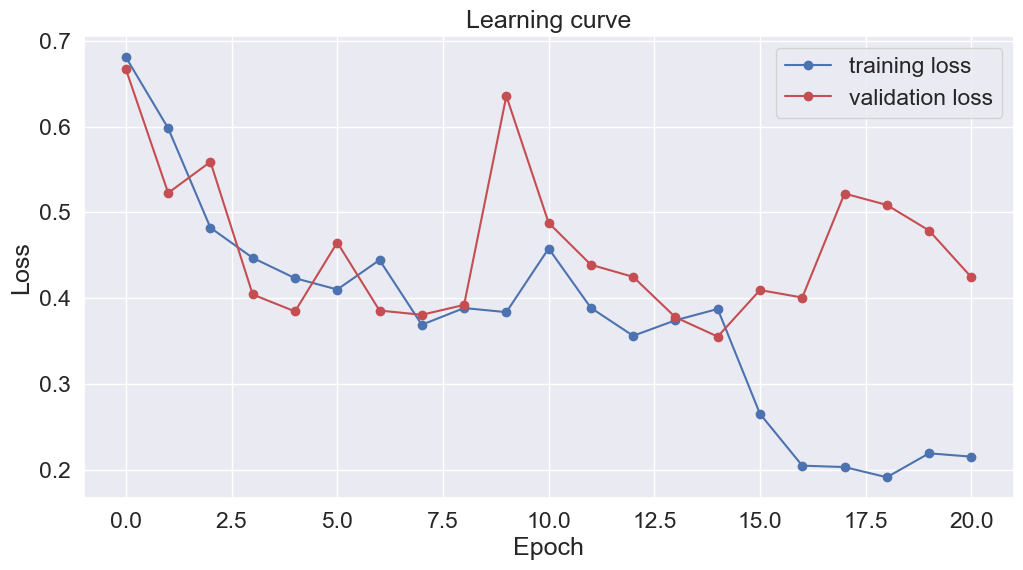

In [9]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(train_loss_values, 'b-o', label="training loss")
plt.plot(val_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [17]:
trainer.save_model(os.path.join(DRIVE_PATH, "model_s_2307/"))

# PREDICT FOR DATASET

In [16]:
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [17]:
saved_model = AutoModelForSequenceClassification.from_pretrained(os.path.join(DRIVE_PATH, "model_s_2307/"))

In [18]:
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
def predict_dataframe(model, tokenizer, df) -> list[str]:
    """Predicts the class for an input dataframe"""

    # Prepare the DataFrame to load by batch for the inference
    dataset = ESGDataset(df=df, tokenizer=tokenizer)
    dataloader = DataLoader(dataset, batch_size=EVAL_BATCH_SIZE)

    # Send the model to the GPU if available
    model.to(DEVICE)

    # Set the model in inference mode
    model.eval()

    predictions = []

    for data in dataloader:

        # Moving to GPU if available
        mask = data['attention_mask'].squeeze(1).to(DEVICE)
        input_id = data['input_ids'].squeeze(1).to(DEVICE)

        # Telling the model not to compute or store gradients
        # This saves memory and speeds up validation
        with torch.no_grad():
            output = model(input_id, token_type_ids=None, attention_mask=mask, labels=None)
        logits = output.logits.to('cpu').numpy()
        pred = np.argmax(np.array(logits), axis=1)
        pred_label = [idx2tag[i] for i in pred]

        predictions.extend(pred_label)

    return predictions

In [52]:
def compute_metrics_by_lang(df: pd.DataFrame) -> pd.DataFrame:

    lang_metrics_df = pd.DataFrame()

    for lang in df["lang"].unique():
        sub_df = df[df["lang"] == lang].reset_index(drop=True)
        metrics = {
            "lang": lang,
            "support": len(sub_df),
            "accuracy": accuracy_score(sub_df["label"].values, sub_df["pred"].values),
            "precision": precision_score(sub_df["label"].values, sub_df["pred"].values, pos_label="ESG"),
            "recall": recall_score(sub_df["label"].values, sub_df["pred"].values, pos_label="ESG"),
            "f1_score": f1_score(sub_df["label"].values, sub_df["pred"].values, pos_label="ESG"),
        }
        lang_metrics_df = pd.concat([lang_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

    return lang_metrics_df

In [28]:
# Predictions for the TRAINING dataset
train_predictions = predict_dataframe(saved_model, tokenizer, train_df)
train_df["pred"] = train_predictions

# Predictions for the VALIDATION dataset
val_predictions = predict_dataframe(saved_model, tokenizer, val_df)
val_df["pred"] = val_predictions

# Predictions for the TEST dataset
test_predictions = predict_dataframe(saved_model, tokenizer, test_df)
test_df["pred"] = test_predictions

In [53]:
compute_metrics_by_lang(test_df)

,lang,support,accuracy,precision,recall,f1_score
0,english,1589,0.869729,0.900599,0.858447,0.879018
1,japanese,29,0.827586,0.818182,0.750000,0.782609
2,italian,17,0.705882,1.000000,0.545455,0.705882
3,french,90,0.844444,0.857143,0.769231,0.810811
4,spanish,41,0.926829,0.900000,1.000000,0.947368
5,portuguese,31,0.741935,0.764706,0.764706,0.764706
6,german,27,0.888889,0.866667,0.928571,0.896552


In [ ]:
train_df.to_csv(os.path.join(DRIVE_PATH, "data_s/train.csv"), index=False)
test_df.to_csv(os.path.join(DRIVE_PATH, "data_s/test.csv"), index=False)
val_df.to_csv(os.path.join(DRIVE_PATH, "data_s/val.csv"), index=False)